## Contexto
### Precálculo
Partimos de nuestro conjunto $C$ que es el área bajo la curva $y=f(x)=\lambda e^{- \lambda x}$. La idea es generar un área $Z$$ tal que $Z \supset C$, este área la conformamos por un conjunto $N$ de cajas con mismo área $v$.
Para maximizar la eficiencia se busca que $N$ sea un múltiplo de 2, de tal manera que se pueda aprovechar la estructura binaria de los ordenadores, y poder asi tomar valores truncando ciertos valores, pero nos estamos adelantando. La idea es que las cajas sean 32, 64, 128, 256, etc. En este caso usaremos 255 para la exponencial concretamente, para la normal se usa 256.

Para generar las cajas en base a nuestro N debemos seguir una relación concreta: TODAS las cajas deben tener área $v$. Definimos las cajas tal que:
$$x_0 = 0 < x_1 < x_2 < ... < x_N = r$$
$$v = x_i [f(x_{i-1}) - f(x_i)] \qquad i= 1, 2, ..., N$$
Esto se define así para todas las cajas, pero para el caso $x_N = r$ no solo contiene la caja, contiene además el área de la cola de la función decreciente, tal que:
$$v = r f(r) +  \int_{r}^{\infty} f(r), dx $$

#### Cálculo de r
Como se puede ver, aún teniendo v dado, este depende de r, por lo que los investigadores nos han proporcionado la función $z(r)$ que nos permite ver si el valor de $r$ que estamos utilizando cumple con las definicinoes y todas las cajas que genera tiene área v. Esta función se define como:

*Algorithm: $z(r)$ para el cálculo del valor óptimo de $r$*  

*Input:*  
$f(x)$ (densidad decreciente),  
$f^{-1}(y)$ (inversa de $f$),  
$N$ (número de rectángulos).  

*Output:*  
$z(r)$ (valor que debe anularse para obtener el $r$ correcto).  

---

1. $( x_N \leftarrow r )$

2. $( v \leftarrow r,\quad f(r) + \displaystyle\int_{r}^{\infty} f(x),dx )$

3. *for* $i = N-1, N-2, \dots, 1$ 
   
   *do:*  
   $\quad x_i \leftarrow f^{-1}\!\left(f(x_{i+1}) + \dfrac{v}{x_{i+1}}\right ) $

4. *return* $z(r) = v - \left(x_1 - x_1 f(x_1)\right) $


---

En este ejercicio trabajaremos únicamente con la distribución normal estándar, por lo que no calcularemos el valor de r ni el área v de forma numérica.
Para simplificar el trabajo, utilizaremos directamente los valores del trabajo original de *Marsaglia y Tsang (2000), “The Ziggurat Method for Generating Random Variables”*, y nos permiten concentrarnos en la comprensión y comparación del método sin añadir complejidad innecesaria en el cálculo de $r $ y $ v $.

**Normal estándar (mitad positiva)**  
$ f(x) = e^{-x^2/2}, \quad x \ge 0 $  
Se usa únicamente la mitad positiva de la normal estándar (sin constante de normalización).  
Para obtener la distribución completa $ N(0,1) $, basta con asignar un signo aleatorio $ \pm1 $ con probabilidad $ 1/2 $.  
En este caso se utilizan **256 rectángulos (N = 256)**, con los valores:
$$
r = 3.442619855899, \qquad
v = 0.00991256303526217
$$

#### Cálculo de las cajas
En este punto ya tenemos r, ya conocemos la relación entre una caja y la anterior y conocemos las restricciones (v) de estas cajas, solo tenemos que invertir la funcion para conseguir calcular todas las cajas:
$$f(x_{i-1}) = f(x_i) + \frac{v}{x_i}$$
$$x_{i-1} = f^{-1}(f(x_i) + \frac{v}{x_i})$$

##### Tablas precalculadas `k`, `w`, `f`

Para optimizar el proceso de generación, se precalculan tres tablas que permiten aceptar aproximadamente el **99 %** de las muestras sin necesidad de evaluar exponenciales.

- **Tabla $f$**  
  Guarda las alturas de la función en los bordes de las cajas:
  $$
  f_i = e^{-\xi_i^2/2}, \quad i=0,\dots,N
  $$
  De esta forma, en la ruta lenta basta una sola evaluación de $f(x)$ para decidir la aceptación:
  $$
  f_i + U(f_{i-1}-f_i) < f(x)
  $$

- **Tabla $w$**  
  Escala los enteros de 31 bits:
  $$
  M = 2^{31}, \qquad w_i = \frac{\xi_i}{M}
  $$
  Garantiza que $x = hz \cdot w_i \in [-\xi_i, +\xi_i]$.

- **Tabla $k$**  
  Define los umbrales para el test rápido de aceptación:
  $$
  k_i = \left\lfloor M \cdot \frac{\xi_{i-1}}{\xi_i} \right\rfloor
  $$
  Si se cumple $|hz| < k_i$, el punto se acepta directamente, ya que cae bajo la curva:
  $$
  |hz| < k_i \Rightarrow x = hz \cdot w_i
  $$

##### Caja base ($i=0$)

La primera caja ($i=0$) es especial porque limita con la cola ($x>r$).  
Se impone que su área sea igual al resto:
$$
q\,f(r) = v \;\;\Longrightarrow\;\; q = \frac{v}{f(r)}
$$
De este modo:
$$
w_0 = \frac{q}{M}, \qquad
k_0 = \left\lfloor \frac{r}{q}\,M \right\rfloor, \qquad
f_0 = f(0) = 1
$$

### Tratamiento de la cola ($i = 0$)

En la distribución normal estándar, la densidad decrece rápidamente:

$$
f(x) = e^{-x^2/2}
$$

Para $x > r$, el valor de $f(x)$ es muy pequeño, pero esta región no puede ignorarse, ya que contribuye al área total bajo la curva.  
Por ello se utiliza el método propuesto por **Marsaglia (1963)**, que permite generar muestras en la cola derecha de manera eficiente mediante aceptación-rechazo.

**Algoritmo (Marsaglia, 1963):**

1. Generar $U_1, U_2 \sim \mathcal{U}(0,1)$  
2. Calcular:
   $$
   x_\Delta \leftarrow \frac{-\ln U_1}{r}, \qquad Y \leftarrow -\ln U_2
   $$
3. Aceptar si:
   $$
   2Y > (x_\Delta)^2
   $$
4. Si se cumple, devolver:
   $$
   x = r + x_\Delta
   $$
   En caso contrario, repetir desde el paso 1.

Este criterio geométrico garantiza que el punto $(x, f(x))$ se encuentra bajo la curva de densidad truncada.  
La probabilidad de rechazo es muy baja (≈10–12 %), por lo que la eficiencia es muy alta.

#### Integración con el algoritmo principal

Cuando el índice de caja es $i = 0$:

1. Se genera un punto en el rectángulo base de altura $f(r)$ y anchura $q$.  
2. Si el punto cae fuera del rectángulo, se entra en la **cola** aplicando el algoritmo anterior.  
3. Finalmente, para obtener la distribución completa $N(0,1)$, se asigna un signo aleatorio con probabilidad $0.5$:
   $$
   x \leftarrow \pm x
   $$

#### Observaciones

- La cola derecha generada con este método sigue exactamente la distribución proporcional a $e^{-x^2/2}$ para $x>r$.  
- El rechazo ocurre con baja frecuencia, manteniendo la eficiencia global del método Ziggurat por encima del **99 %**.


### Generador base

El método utiliza un generador uniforme de 32 bits (e.g. SHR3) con excelente distribución de bits bajos y periodo $2^32 -1$
Esto permite indexar cajas con los 8 bits menos significativos y obtener valores candidatos con multiplicaciones rápidas.

En nuestro caso lastimosamente no encontramos un generador de secuecnias de bits facilmente, así que hemos usado el generador disponible en numpy **Mersenne Twister**, pues es fiable y tiene un periodo muy grande.

### Algoritmo Generador

Ahora que ya tenemos las cajas  podemos mostrar como es el algoritmo de Ziggurat a la hora de generar distribuciones.

---

*Algorithm: Generación de una variable aleatoria mediante el método de Ziggurat (con tratamiento de colas de Marsaglia, 1963)*  

*Input:*  
$f(x)$ (función de densidad decreciente),  
$\{x_i\}, \{f_i\}$ (tablas precalculadas),  
$r, v, N$ (parámetros del ziggurat).  

*Output:*  
$x$ (valor aleatorio con la distribución objetivo).  

---

1. Generar un entero aleatorio de 32 bits $j$.

2. Obtener el índice de caja:
   $$
   i \leftarrow j \; \&\; (N-1)
   $$
   (usa los bits bajos de $j$).

3. Calcular el candidato:
   $$
   x \leftarrow |j| \cdot w[i]
   $$
   donde $w[i] = \dfrac{x_i}{2^{32}}$.

4. **Comprobación rápida:**  
   Si $|j| < k[i]$ entonces **aceptar directamente** y devolver $x$  
   (se encuentra en la parte segura del rectángulo, bajo la curva).

5. Caso cola (i = 0):
   1. Generar $U_1, U_2 \sim \mathcal{U}(0,1)$
   2. $x_\Delta \leftarrow \dfrac{-\ln U_1}{r}$
   3. $Y \leftarrow -\ln U_2$
   4. Si $2Y > (x_\Delta)^2$, devolver $r + x_\Delta$; en caso contrario, repetir paso 5


   - **Caso caja interna (i > 0):**
     1. Calcular $f(x) = e^{-x^2/2}$ (o la correspondiente para la distribución).
     2. Aceptar si
        $$
        f(x) > f_i + \dfrac{f_{i-1} - f_i}{x_i - x_{i-1}}(x - x_i)
        $$
        (el punto está bajo la curva).  
        Si no, repetir desde el paso 1.

6. Para la **normal**, asignar signo aleatorio:
   $$
   x \leftarrow \pm x \quad \text{con prob. } 0.5
   $$

7. Devolver $x$.Tenemos que generar la tabla de la normal estándar $N(0,1)$. 


Empecemos escogiendo nuestro generador uniforme en este caso tomaremos Mersenne Twister por su fiabilidad y por su periodo tan grande, que está implementado en la libreria numpy

In [2]:
import numpy as np

# Crear generador basado en Mersenne Twister
mt = np.random.MT19937(seed=43)
rng = np.random.Generator(mt)

print([rng.random() for _ in range(10)])

[0.6057220977812905, 0.9245321580950842, 0.6383927532488509, 0.11361476091492895, 0.7447303871101164, 0.42490588783923344, 0.46765813308716786, 0.018731721960731584, 0.0075794920916104624, 0.7952568777367439]


Queremos obtener los puntos $x_i$ que delimitan las cajas del ziggurat, con:

$$
x_i [f(x_{i-1}) - f(x_i)] = v, \quad \text{para } i = 1,\dots,N
$$

y el borde final:

$$
v = r f(r) + \int_r^{\infty} f(x)\,dx
$$

Cada caja tiene área $v$, y los $x_i$ decrecen hasta que $x_0 = 0$.
La última caja ($i = N$) termina en $x_N = r$.

Para resolverlo, necesitamos:

1. Fijar $r$ y $v$.
2. Partir de $x_N = r$.
3. Calcular recursivamente los $x_i$ hacia abajo:
   $$
   x_i = f^{-1}\left(f(x_{i+1}) + \frac{v}{x_{i+1}}\right)
   $$
   donde $f^{-1}(y)$ se obtiene como:
   $$
   f^{-1}(y) = \sqrt{-2 \ln(y)}
   $$
   (porque $f(x) = e^{-x^2/2}$).


In [3]:
n_capas=128
r=3.442619855899
v=9.91256303526217e-3

In [4]:
import numpy as np

def generar_capas(n_capas=128, r=3.442619855899, v=9.91256303526217e-3):
    """
    Calcula los bordes x_i de las cajas del ziggurat para la normal estándar (lado positivo).

    np.ndarray
        Array con los bordes x_i (de longitud n_layers), desde x_0=0 hasta x_N=r.
    """
    # Función densidad sin normalizar (lado positivo)
    f = lambda x: np.exp(-0.5 * x * x)

    # Array de bordes (x_0, ..., x_N)
    x_list = np.zeros(n_capas, dtype=np.float64)
    x_list[-1] = r  # último borde

    # Recorremos hacia abajo desde la última capa hasta la primera
    for i in range(n_capas - 2, -1, -1): # recorremos por indice de la penultima caja hacia atras
        #f_inv(y) = sqrt(-2 ln y)
        y = f(x_list[i + 1]) + v / x_list[i + 1] # calculamos el y de la caja
        x_list[i] = np.sqrt(-2.0 * np.log(y)) # obtenemos la x aplicando f_inv(y)

    return x_list


In [5]:
generar_capas()

array([9.33425437e-06, 2.72320865e-01, 3.62871431e-01, 4.26547986e-01,
       4.77437837e-01, 5.20656039e-01, 5.58692178e-01, 5.92962942e-01,
       6.24358597e-01, 6.53478639e-01, 6.80747919e-01, 7.06479611e-01,
       7.30911911e-01, 7.54230664e-01, 7.76583988e-01, 7.98092061e-01,
       8.18853907e-01, 8.38952214e-01, 8.58456843e-01, 8.77427429e-01,
       8.95915353e-01, 9.13965251e-01, 9.31616197e-01, 9.48902626e-01,
       9.65855079e-01, 9.82500804e-01, 9.98864233e-01, 1.01496740e+00,
       1.03083024e+00, 1.04647090e+00, 1.06190596e+00, 1.07715062e+00,
       1.09221888e+00, 1.10712365e+00, 1.12187692e+00, 1.13648985e+00,
       1.15097284e+00, 1.16533564e+00, 1.17958738e+00, 1.19373671e+00,
       1.20779175e+00, 1.22176023e+00, 1.23564948e+00, 1.24946650e+00,
       1.26321796e+00, 1.27691027e+00, 1.29054959e+00, 1.30414185e+00,
       1.31769278e+00, 1.33120795e+00, 1.34469275e+00, 1.35815245e+00,
       1.37159220e+00, 1.38501704e+00, 1.39843191e+00, 1.41184171e+00,
      

## Explicación paso a paso

### 1. **Qué representan las cajas**
Cada caja del ziggurat tiene **área constante = $v$**.  
Para la normal estándar, esas cajas recubren la curva $f(x) = e^{-x^2/2}$ en el lado positivo.  
La última caja termina en $x_N = r$ y la primera en $x_0 \approx 0$.

---

### 2. **Ecuación de área por caja**
El área del rectángulo $i$ es:
$$
A_i = x_i \,\big[f(x_{i-1}) - f(x_i)\big] = v
$$
De aquí se obtiene la relación:
$$
f(x_{i-1}) = f(x_i) + \frac{v}{x_i}
$$

---

### 3. **Inversión de $f$ para recuperar $x$**
Como $f(x) = e^{-x^2/2}$, su inversa en el lado positivo es:
$$
f^{-1}(y) = \sqrt{-2\ln(y)}
$$
Sustituyendo en la relación anterior:
$$
x_{i-1} = \sqrt{-2\,\ln\!\left(f(x_i) + \frac{v}{x_i}\right)}
$$
Esto permite calcular recursivamente $x_{i-1}$ conociendo $x_i$.

---

### 4. **Condición de cierre en el borde derecho**
El borde final $r$ y el área común $v$ satisfacen:
$$
v = r\,f(r) + \int_{r}^{\infty} f(x)\,dx
$$
Con los valores del paper (para 128 capas en el lado positivo):  
$$
r = 3.442619855899,\quad v = 9.91256303526217\times10^{-3}
$$
se garantiza que la base (rectángulo + cola) tiene también área $v$.

---

### 5. **Algoritmo de construcción de bordes**
1) Fijar $x_N = r$.  
2) Para $i = N-1, N-2, \dots, 1, 0$:
$$
x_i \leftarrow \sqrt{-2\,\ln\!\left(f(x_{i+1}) + \frac{v}{x_{i+1}}\right)}
$$
3) Al finalizar, se obtiene la secuencia $x_0, x_1, \dots, x_N$ con $x_0 \approx 0$ y $x_N = r$.

---

### 6. **Comprobación rápida**
La última caja debe cumplir:
$$
x_N \,\big[f(x_{N-1}) - f(x_N)\big] \approx v
$$
Numéricamente, al evaluar con doble precisión, debe dar un valor muy cercano a $9.912563\times10^{-3}$.

---

### 7. **Uso posterior**
Con los bordes $x_i$ calculados:
- Se tabulan $f_i = f(x_i)$ para todas las capas.
- Se construirán después las tablas de aceleración $k_i$ y $w_i$:
  $$
  k_i \approx \Big\lfloor 2^{31}\,\frac{x_{i-1}}{x_i}\Big\rfloor,\qquad
  w_i = \frac{x_i}{2^{31}}
  $$
Estas tablas permiten el **test rápido** del Ziggurat: con un entero con signo de 32 bits $hz$,  
se usa el índice $i = (hz \,\&\, 127)$ y se acepta si $\lvert hz\rvert < k_i$, devolviendo $x = hz \cdot w_i$.


# 🧮 Tablas precalculadas del Ziggurat (normal estándar, lado positivo)

A partir de los bordes $x_i$ (cajas de área $v$ calculadas en el paso anterior), construimos las **tablas del test rápido**:  
- $k_i$ (umbrales enteros),  
- $w_i$ (factores de escala),  
- $f_i = f(x_i)$ (densidad en los bordes).

Estas tablas hacen posible que, en $\sim 99\%$ de los casos, la muestra se obtenga con:
- **dos accesos a tabla**,  
- **una comparación** $|hz| < k_i$,  
- **una multiplicación** $x = hz \cdot w_i$.

---

## 🔢 Definiciones (consistentes con el paper)

Para la **normal estándar** usando la densidad **sin normalizar** $f(x) = e^{-x^2/2}$ y **128 capas** en el lado positivo:

- Escala entera (31 bits efectivos):  
  $$
  M = 2^{31}
  $$

- Para $i \ge 1$:
  $$
  k_i = \left\lfloor M \cdot \frac{x_{i-1}}{x_i} \right\rfloor,
  \qquad
  w_i = \frac{x_i}{M},
  \qquad
  f_i = f(x_i) = e^{-x_i^2/2}
  $$

- Fila especial $i=0$ (base + cola):
  Sea $r = x_{N}$ y $v$ el área común por capa, entonces
  $$
  q = \frac{v}{f(r)},\qquad
  k_0 = \left\lfloor \frac{r}{q} \cdot M \right\rfloor,\qquad
  w_0 = \frac{q}{M},\qquad
  f_0 = f(0) = 1
  $$

> **Intuición:** $k_i$ codifica la **proporción de anchos** $x_{i-1}/x_i$ a la escala entera $M$.  
> $w_i$ permite transformar el entero con signo $hz \in [-2^{31},2^{31}\!-\!1]$ a un real $x \approx \pm x_i$.  
> $f_i$ evita evaluar exponenciales salvo en la **ruta lenta** ($<1\%$ de los casos).


In [6]:
import numpy as np


def generar_tablas_precalculadas(x_list: np.ndarray, v: float):
    """
    Construye las tablas k, w, f del Ziggurat (normal estándar, lado positivo)
    a partir de los bordes x_i (longitud N, con x[0]≈0 y x[-1]=r) y el área común v.
    """
    x_list = np.asarray(x_list, dtype=np.float64)
    N = x_list.size
    
    if N < 2:
        raise ValueError("Se requieren al menos 2 bordes: x_0≈0 y x_{N-1}=r.")

    # Densidad sin normalizar: f(x) = exp(-x^2/2)
    f_list = np.exp(-0.5 * x_list * x_list)

    # Escala entera M = 2^31 (como en Marsaglia & Tsang para la normal)
    M = float(2**31)

    # Tablas a rellenar
    k_list = np.zeros(N, dtype=np.uint32)
    w_list = np.zeros(N, dtype=np.float64)

    # (A) Filas i>=1: relaciones directas entre bordes adyacentes
    # k[i] = floor( M * x[i-1] / x[i] )
    # w[i] = x[i] / M
    # Nota: x[0]≈0 -> k[1]=0 como en el código clásico.
    w_list[1:] = x_list[1:] / M
    with np.errstate(divide="ignore", invalid="ignore"):
        ratio = x_list[:-1] / x_list[1:]
        ratio = np.where(x_list[1:] > 0, ratio, 0.0)
    k_list[1:] = np.floor(M * ratio).astype(np.uint32)

    # (B) Fila i=0 (base + cola): usa q = v / f(r)
    r = x_list[-1]
    fr = f_list[-1]
    if fr <= 0.0:
        raise ValueError("f(r) es 0")
    q = v / fr
    # k[0] = floor( (r/q) * M ), w[0] = q / M
    k_list[0] = np.uint32(np.floor((r / q) * M))
    w_list[0] = q / M

    return k_list, w_list, f_list

## Explicación paso a paso (tablas precalculadas `k`, `w`, `f`)

### 1. **Objetivo de las tablas**
Las tablas `k`, `w` y `f` permiten que, en ≈99% de los casos, una muestra se acepte con:
- **un índice de capa** $i$,
- **una comparación entera** $|hz|<k_i$,
- **una multiplicación** $x = hz\cdot w_i$,

sin calcular exponenciales. Trabajamos en el **lado positivo** de la normal estándar con la densidad **no normalizada**:
$$
f(x)=e^{-x^2/2},\qquad x\ge 0,
$$
y con los bordes $\{\xi_i\}_{i=0}^{N}$ de las cajas de **área constante** $v$:
$$
\xi_i\,[f(\xi_{i-1})-f(\xi_i)] = v,\quad i=1,\dots,N,\qquad \xi_N=r.
$$

---

### 2. **Tabla $f$ (alturas en los bordes)**
Definimos la tabla de alturas de la densidad en los bordes:
$$
f_i \equiv f(\xi_i) = e^{-\xi_i^2/2},\qquad i=0,\dots,N.
$$
**¿Por qué?** En la **ruta lenta** (cuando falla el test rápido), la aceptación se decide con:
$$
f_i + U\,(f_{i-1}-f_i) \;<\; f(x), \qquad U\sim\mathcal U(0,1).
$$
Tabular $f_i$ evita recalcular exponenciales en los bordes; solo se evalúa $f(x)$ una vez.

---

### 3. **Escala entera y tabla $w$ (factor de escala)**
El Ziggurat usa un entero con signo de 32 bits $hz$ con **31 bits efectivos** para la magnitud. Fijamos:
$$
M = 2^{31}.
$$
Para $i\ge 1$:
$$
w_i \;=\; \frac{\xi_i}{M}.
$$
**Intuición:** si $|hz|<M$, entonces $x=hz\cdot w_i \in [-\xi_i,\,+\xi_i]$ (aplicando el signo de $hz$ para cubrir el lado negativo).

---

### 4. **Tabla $k$ (umbrales del test rápido) para $i\ge 1$**
Para $i\ge 1$:
$$
k_i \;=\; \left\lfloor\, M\cdot \frac{\xi_{i-1}}{\xi_i}\,\right\rfloor.
$$
**Papel de $k_i$:** implementa el **test rápido**:
$$
\text{si } |hz|<k_i \;\Longrightarrow\; \text{aceptar}\;\; x = hz\cdot w_i.
$$
Geométricamente, garantiza que el punto candidato cae **dentro del rectángulo** de la caja $i$ sin mirar la curva.  
Como $\xi_0\approx 0$, se cumple $k_1=\lfloor M\,\xi_0/\xi_1\rfloor=0$ (coincide con el código clásico).

---

### 5. **Caja base ($i=0$): por qué es distinta y por qué aparece $q$**
La fila $i=0$ (la **base**) es especial porque linda con la **cola** ($x>r$).  
Elegimos la base como un rectángulo de **anchura** $q$ y **altura** $f(r)$ con **área igual** a la de cualquier caja:
$$
q\,f(r)=v \;\;\Longrightarrow\;\; q=\frac{v}{f(r)}.
$$
Así, la probabilidad de caer en la base (rectángulo) coincide con la de cualquier otra caja.

Con este $q$ definimos:
$$
w_0=\frac{q}{M},\qquad
k_0=\left\lfloor \frac{r}{q}\,M\right\rfloor,\qquad
f_0=f(0)=1.
$$
**Por qué $\frac{r}{q}$ en $k_0$:** para la base no hay cociente $\xi_{-1}/\xi_0$; el **análogo geométrico** que fija el umbral entero es la razón entre el **límite derecho** $r$ y la **anchura** $q$ del rectángulo base, jugando el mismo papel que $\xi_{i-1}/\xi_i$ en las demás capas.

---

### 6. **Construcción algorítmica (de bordes a tablas)**
Dados los bordes $\{\xi_i\}$ (con $\xi_N=r$) y el $v$ del paper:
1) **Alturas**:
$$
f_i = e^{-\xi_i^2/2},\quad i=0,\dots,N.
$$
2) **Escalas** ($i\ge 1$):
$$
w_i = \frac{\xi_i}{2^{31}}.
$$
3) **Umbrales** ($i\ge 1$):
$$
k_i = \left\lfloor 2^{31}\cdot \frac{\xi_{i-1}}{\xi_i}\right\rfloor.
$$
4) **Base** ($i=0$): con $q=\dfrac{v}{f(r)}$,
$$
w_0=\frac{q}{2^{31}},\qquad
k_0=\left\lfloor \frac{r}{q}\,2^{31}\right\rfloor,\qquad
f_0=1.
$$

---

### 7. **Comprobaciones rápidas**
- **Escala correcta en la última capa**:
$$
w_N\cdot 2^{31}\;\approx\; \xi_N \;=\; r.
$$
- **Primer umbral nulo**:
$$
k_1=\left\lfloor 2^{31}\cdot \frac{\xi_0}{\xi_1}\right\rfloor = 0 \quad (\xi_0\approx 0).
$$
- **Base de área $v$**:
$$
q\,f(r)=v\;\;\Longrightarrow\;\; q=\frac{v}{f(r)}.
$$

---

### 8. **Uso posterior en el generador**
- **Test rápido (≈99%)**: con $i=(hz\ \&\ 127)$,
$$
|hz|<k_i\;\Longrightarrow\; x=hz\cdot w_i \;\;(\text{aceptado}).
$$
- **Ruta lenta (≈1%)**: se evalúa **una** exponencial y se compara con las alturas tabuladas:
$$
f_i + U\,(f_{i-1}-f_i) \;<\; f(x).
$$
- **Cola** ($i=0$ cuando toca): se usa el algoritmo específico de cola para $x>r$.


In [7]:
import numpy as np

def cola_normal(u1: float, u2: float, r: float) -> float | None:
    """
    Paso atómico de la cola derecha de N(0,1).
    Devuelve r + (-ln u1)/r si se acepta; None si se rechaza.
    """
    # Comprobación básica de rango
    if not (0.0 < u1 < 1.0 and 0.0 < u2 < 1.0):
        raise ValueError("u1 y u2 deben estar en (0,1).")

    x = -np.log(u1) / r
    y = -np.log(u2)

    # Test de aceptación de Marsaglia (1963): aceptar si 2*y > x^2
    accepted = (2.0 * y) > (x * x)
    if accepted:
        return r + x
    else:
        return None



In [8]:
cola_normal(rng.random(), rng.random(), r=r)

np.float64(3.532741295608391)

## Explicación paso a paso (tratamiento de la cola en el Ziggurat normal)

### 1. **Qué problema resolvemos**
En la distribución normal estándar, la densidad decrece rápidamente:
$$
f(x) = e^{-x^2/2}.
$$
Para $x > r$ (por ejemplo $r \approx 3.4426$ en el Ziggurat de 128 capas), el valor de $f(x)$ es tan pequeño que  
las áreas de esas regiones son ínfimas y la probabilidad de obtener una muestra allí es muy baja.  
Sin embargo, **no podemos ignorar esa región**: el área total bajo la curva debe seguir siendo 1.

Por eso se crea un método especializado para muestrear correctamente en la **cola derecha**:
$$
X \sim \mathcal N(0,1)\ \big|\ X > r.
$$
Gracias a la simetría de la normal, la cola izquierda se obtiene simplemente aplicando un signo negativo.

---

### 2. **Fundamento del método de Marsaglia (1963)**
Marsaglia propuso un método de aceptación-rechazo muy eficiente para muestrear la cola de la normal:

1. Genera dos uniformes $U_1, U_2 \sim \mathcal U(0,1)$.
2. Calcula:
   $$
   X^\star = r + \frac{-\ln U_1}{r}, \qquad Y = -\ln U_2.
   $$
3. **Acepta** $X^\star$ si:
   $$
   2Y > \left(\frac{-\ln U_1}{r}\right)^2.
   $$
4. Si no se cumple, repite con nuevos $U_1, U_2$.

El valor final $X^\star$ tendrá densidad proporcional a $f(x) = e^{-x^2/2}$ en $x>r$.

---

### 3. **Por qué funciona**
El método transforma la cola $x>r$ en una región en el plano $(U_1,U_2)$ en la que es fácil aplicar un
**criterio de aceptación geométrico**.  
El rechazo se produce con baja probabilidad (≈ 10–12%) cuando $r\approx 3$–$3.5$,  
por lo que la eficiencia es muy alta.

Geométricamente, la condición $2Y > (\ln U_1 / r)^2$ asegura que el punto simulado cae bajo la curva de la densidad truncada.

---

### 4. **Integración con el Ziggurat**
En el Ziggurat, la **última caja (i = 0)** está formada por:

- Un **rectángulo** de altura $f(r)$ y anchura $q$,  
- Una **cola** que comienza en $r$ y continúa hasta $\infty$.

El área del rectángulo se define igual que las demás cajas:
$$
q\,f(r) = v \quad \Longrightarrow \quad q = \frac{v}{f(r)}.
$$
Por tanto, la probabilidad de caer en la “base” o en la “cola” es coherente con el resto del diseño del ziggurat.

Cuando el índice de caja es $i=0$, el algoritmo hace:
1. Genera un punto en la base rectangular con probabilidad proporcional a $r\,f(r) / v$.
2. Si cae fuera del rectángulo, entra en la **cola** y se genera una muestra con el método anterior.

El signo del número base ($hz$) se utiliza para reflejar simétricamente la muestra:  
si $hz<0$, el resultado se multiplica por $-1$.


In [9]:
#generar_capas()
k, w, f = generar_tablas_precalculadas(generar_capas(), v)

In [10]:
f

array([1.        , 0.96359969, 0.93628268, 0.91304365, 0.89228165,
       0.87324305, 0.85550061, 0.83878361, 0.82290721, 0.80773829,
       0.79317701, 0.77914609, 0.76558417, 0.75244156, 0.73967724,
       0.72725692, 0.71515151, 0.7033361 , 0.69178914, 0.68049184,
       0.66942767, 0.658582  , 0.64794182, 0.63749548, 0.62723249,
       0.61714337, 0.60721954, 0.59745315, 0.58783705, 0.57836468,
       0.56902999, 0.55982741, 0.55075179, 0.54179836, 0.53296266,
       0.52424057, 0.51562824, 0.50712205, 0.49871864, 0.49041483,
       0.48220765, 0.4740943 , 0.46607215, 0.45813872, 0.45029164,
       0.44252872, 0.43484783, 0.427247  , 0.41972433, 0.41227804,
       0.40490642, 0.39760786, 0.39038081, 0.38322381, 0.37613547,
       0.36911445, 0.3621595 , 0.35526938, 0.34844297, 0.34167914,
       0.33497685, 0.3283351 , 0.32175292, 0.31522939, 0.30876364,
       0.30235483, 0.29600216, 0.28970486, 0.28346221, 0.2772735 ,
       0.27113808, 0.2650553 , 0.25902457, 0.2530453 , 0.24711

In [11]:
hz = rng.integers(np.iinfo(np.int32).min, np.iinfo(np.int32).max, dtype=np.int32)
print("numero original:         ",hz)
print("numero original binario: ",np.binary_repr(hz))
print("longitud numero binario: ",len(np.binary_repr(hz)))
print("mascara:                 ", np.binary_repr(np.int32(127)))
print("7 ultimos bits:          ",np.binary_repr(hz)[-7:])
print("resultado AND:           ",np.binary_repr(int(abs(hz) & np.int32(127))))
print("resultado AND COMPLETO:  ",np.binary_repr(hz & np.int32(127)))
print("resultado AND COMPLETO:  ",abs(hz) & np.int32(127))



numero original:          -1640115466
numero original binario:  -1100001110000100010110100001010
longitud numero binario:  32
mascara:                  1111111
7 ultimos bits:           0001010
resultado AND:            1010
resultado AND COMPLETO:   1110110
resultado AND COMPLETO:   10


In [12]:
hz = rng.integers(np.iinfo(np.int32).min, np.iinfo(np.int32).max, dtype=np.int32)
abs(hz) & np.int32(127)

np.int32(57)

In [13]:
128 & 127

0

In [14]:
float(hz)

-1093000121.0

In [ ]:
def primer_trozo():
    N = k.size
    # 1) Entero base int32 (31 bits magnitud + 1 bit de signo)
    hz = rng.integers(np.iinfo(np.int32).min, np.iinfo(np.int32).max, dtype=np.int32)

    # 2) Índice de capa (asume N potencia de 2: típico N=128); si no lo es, usar % N
    iz = abs(hz) & np.int32(127)

    # 3) Test rápido
    abs_hz = np.uint32(abs(int(hz)))
    if abs_hz < k[iz]:
        print("ruta rapida -> ", float(hz) * float(w[iz]))
    print("iz: ",iz)
    sign = 1.0 if hz >= 0 else -1.0
    if iz == 0:
        # 4a) COLA (i == 0): reintentar hasta aceptar un valor > r y aplicar signo
        u1 = abs_hz / np.float64(2**32)
        u2 = rng.random()
        while True:
            u2 = rng.random()
            x_pos = cola_normal(u1, u2, r)  # None si rechaza
            if x_pos is not None:
                print("result capa 1: ", sign * x_pos)
                break
            u1 = rng.random()   
            u2 = rng.random()  
    return izdef cola_normal(r: float, rng: np.random.Generator, u1_inicial: float = None) -> float:
    """
    Genera un valor de la cola derecha de N(0,1) (x > r).
    Usa el método de Marsaglia (1963) optimizado.
    
    Args:
        r: límite de la cola
        rng: generador de números aleatorios
        u1_inicial: primer uniforme (opcional, reutilizado de hz*w[0])
    """
    # Primera iteración: usa u1_inicial si se proporciona
    u1 = u1_inicial if u1_inicial is not None else rng.random()
    
    while True:
        u2 = rng.random()
        
        x = -np.log(u1) / r
        y = -np.log(u2)
        
        # Test de aceptación: aceptar si 2*y > x^2
        if (y + y) > (x * x):
            return r + x
        
        # Rechazado: genera nuevo u1 para siguiente iteración
        u1 = rng.random()


In [ ]:
x_u = x.view(np.uint32)                 # misma memoria, sin overflow
u = x_u / np.float64(2**32)

In [91]:
import time

iz = -1
count=0
while iz != 0:
    iz = primer_trozo()
    count+=1
    time.sleep(0.01)
    
print("iz bucle: ",iz)
print("counting: ",count)

ruta rapida ->  0.6461762505672228
iz:  71
ruta rapida ->  0.17799458656048803
iz:  41
ruta rapida ->  0.6453536694259532
iz:  46
ruta rapida ->  1.4128645434658011
iz:  116
ruta rapida ->  -1.6266794480650812
iz:  101
ruta rapida ->  1.8610527386526547
iz:  121
ruta rapida ->  -1.1545960917697673
iz:  77
ruta rapida ->  0.8405716994628922
iz:  117
ruta rapida ->  1.8018552440096252
iz:  119
ruta rapida ->  0.37524068741776845
iz:  66
ruta rapida ->  -0.6711590221559178
iz:  106
ruta rapida ->  -1.762369595201126
iz:  103
ruta rapida ->  1.7870231597429285
iz:  96
ruta rapida ->  -0.4408093116571308
iz:  7
ruta rapida ->  -0.6617199059165888
iz:  26
ruta rapida ->  1.6250614812633928
iz:  120
ruta rapida ->  0.07702523782321206
iz:  72
ruta rapida ->  0.14844438257485287
iz:  62
ruta rapida ->  0.39035112787603354
iz:  20
ruta rapida ->  0.16147673075648253
iz:  24
ruta rapida ->  -1.5431216527272407
iz:  90
ruta rapida ->  1.5900514576787739
iz:  109
ruta rapida ->  1.3955513475220258

In [34]:
x = rng.integers(np.iinfo(np.int32).min, np.iinfo(np.int32).max, dtype=np.int32)
u = float((x - np.iinfo(np.int32).min) / (np.iinfo(np.int32).max - np.iinfo(np.int32).min + 1))
u

0.0066342412028461695

In [64]:
x = rng.integers(np.iinfo(np.int32).min, np.iinfo(np.int32).max, dtype=np.int32)

x_u = x.view(np.uint32)                 # misma memoria, sin overflow
u = x_u / np.float64(2**32)

print(u)

0.5533526882063597


In [ ]:
import numpy as np

def sample_tail_once(rng: np.random.Generator, r: float) -> float:
    while True:
        u1 = rng.random()
        u2 = rng.random()
        x = cola_normal(u1, u2, r)
        if x is not None:
            return x  # > r


def ziggurat_norm_one(
    rng: np.random.Generator,
    k: np.ndarray,        # uint32, shape (N,)
    w: np.ndarray,        # float64, shape (N,)
    f: np.ndarray,        # float64, shape (N,), f[i]=exp(-xi[i]^2/2)
    xi: np.ndarray,       # float64, shape (N,), bordes lado positivo (xi[0]≈0, xi[-1]=r)
    r: float              # límite derecho (xi[-1])
) -> float:
    """
    Genera UNA muestra ~ N(0,1) usando el método Ziggurat (Marsaglia & Tsang, 2000),
    con tablas precalculadas (k, w, f, xi). Devuelve un float.

    Reglas:
      - Test rápido: |hz| < k[i]  -> x = hz * w[i] (aceptado)
      - Si i == 0 y falla: cola (x>r) con Marsaglia 1963; aplicar signo de hz
      - Si i > 0 y falla: tiras (rechazo local) con alturas tabuladas f[i-1], f[i]
    """
    
    # 1) Entero base int32 (31 bits magnitud + 1 bit de signo)
    hz = rng.integers(np.iinfo(np.int32).min, np.iinfo(np.int32).max, dtype=np.int32)

    # 2) Índice de capa (asume N potencia de 2: típico N=128); si no lo es, usar % N
    iz = abs(hz) & np.int32(127)

    # 3) Test rápido
    abs_hz = np.uint32(abs(int(hz)))
    if abs_hz < k[iz]:
        return float(hz) * float(w[iz])

    # 4) Ruta lenta
    sign = 1.0 if hz >= 0 else -1.0

    if iz == 0:
        # 4a) COLA (i == 0): reintentar hasta aceptar un valor > r y aplicar signo
        u1 = abs_hz / np.float64(2**32)
        u2 = rng.random()
        while True:
            u2 = rng.random()
            x_pos = cola_normal(u1, u2, r)  # None si rechaza
            if x_pos is not None:
                return sign * x_pos
            u1 = rng.random()   
            u2 = rng.random()       
    else:
        # 4b) TIRAS (i > 0): propuesta uniforme en la base de la capa i y rechazo local
        i = iz
        while True:
            # Propuesta: x = ± U * xi[i], con U ~ Unif(0,1)
            Ux = rng.random()
            x = sign * (Ux * float(xi[i]))

            # Altura uniforme en la tira: f[i] + U2*(f[i-1] - f[i])
            Uy = rng.random()
            lhs = float(f[i]) + Uy * (float(f[i - 1]) - float(f[i]))
            rhs = float(np.exp(-0.5 * x * x))  # f(x)

            if lhs < rhs:
                return x


# ======================
# Ejemplo de ejecución:
# ======================
if __name__ == "__main__":
    # Usa lo que ya definiste antes en tu notebook:
    # rng, n_capas, r, v, generar_capas, generar_tablas_precalculadas, cola_normal_step_np
    x_list = generar_capas(n_capas, r, v)
    k, w, f = generar_tablas_precalculadas(x_list, v)
    muestras = ziggurat_norm(500_000, rng, x_list, k, w, f, r)

    print("Media   ≈ 0:", float(np.mean(muestras)))
    print("DesvTip ≈ 1:", float(np.std(muestras)))
    # Percentiles de control
    print("p99.5:", float(np.percentile(muestras, 99.5)))
    print("p99.9:", float(np.percentile(muestras, 99.9)))


NameError: name 'ziggurat_norm' is not defined

In [ ]:
import numpy as np

# Crear generador basado en Mersenne Twister
mt = np.random.MT19937(seed=43)
rng = np.random.Generator(mt)

def generar_tablas_precalculadas(x_list: np.ndarray, v: float):
    """
    Construye las tablas k, w, f del Ziggurat (normal estándar, lado positivo)
    a partir de los bordes x_i (longitud N, con x[0]≈0 y x[-1]=r) y el área común v.
    """
    x_list = np.asarray(x_list, dtype=np.float64)
    N = x_list.size
    
    if N < 2:
        raise ValueError("Se requieren al menos 2 bordes: x_0≈0 y x_{N-1}=r.")

    # Densidad sin normalizar: f(x) = exp(-x^2/2)
    f_list = np.exp(-0.5 * x_list * x_list)

    # Escala entera M = 2^31 (como en Marsaglia & Tsang para la normal)
    M = float(2**31)

    # Tablas a rellenar
    k_list = np.zeros(N, dtype=np.uint32)
    w_list = np.zeros(N, dtype=np.float64)

    # (A) Filas i>=1: relaciones directas entre bordes adyacentes
    # k[i] = floor( M * x[i-1] / x[i] )
    # w[i] = x[i] / M
    # Nota: x[0]≈0 -> k[1]=0 como en el código clásico.
    w_list[1:] = x_list[1:] / M
    with np.errstate(divide="ignore", invalid="ignore"):
        ratio = x_list[:-1] / x_list[1:]
        ratio = np.where(x_list[1:] > 0, ratio, 0.0)
    k_list[1:] = np.floor(M * ratio).astype(np.uint32)

    # (B) Fila i=0 (base + cola): usa q = v / f(r)
    r = x_list[-1]
    fr = f_list[-1]
    if fr <= 0.0:
        raise ValueError("f(r) es 0")
    q = v / fr
    # k[0] = floor( (r/q) * M ), w[0] = q / M
    k_list[0] = np.uint32(np.floor((r / q) * M))
    w_list[0] = q / M

    return k_list, w_list, f_list

def cola_normal(u1: float, u2: float, r: float) -> float | None:
    """
    Paso atómico de la cola derecha de N(0,1).
    Devuelve r + (-ln u1)/r si se acepta; None si se rechaza.
    """
    # Comprobación básica de rango
    if not (0.0 < u1 < 1.0 and 0.0 < u2 < 1.0):
        raise ValueError("u1 y u2 deben estar en (0,1).")

    x = -np.log(u1) / r
    y = -np.log(u2)

    # Test de aceptación de Marsaglia (1963): aceptar si 2*y > x^2
    accepted = (2.0 * y) > (x * x)
    if accepted:
        return r + x
    else:
        return None


def ziggurat_norm_one(
    rng: np.random.Generator,
    k: np.ndarray,        # uint32, shape (N,)
    w: np.ndarray,        # float64, shape (N,)
    f: np.ndarray,        # float64, shape (N,), f[i]=exp(-xi[i]^2/2)
    xi: np.ndarray,       # float64, shape (N,), bordes lado positivo (xi[0]≈0, xi[-1]=r)
    r: float              # límite derecho (xi[-1])
) -> float:
    """
    Genera UNA muestra ~ N(0,1) usando el método Ziggurat (Marsaglia & Tsang, 2000),
    con tablas precalculadas (k, w, f, xi). Devuelve un float.

    Reglas:
      - Test rápido: |hz| < k[i]  -> x = hz * w[i] (aceptado)
      - Si i == 0 y falla: cola (x>r) con Marsaglia 1963; aplicar signo de hz
      - Si i > 0 y falla: tiras (rechazo local) con alturas tabuladas f[i-1], f[i]
    """
    
    # 1) Entero base int32 (31 bits magnitud + 1 bit de signo)
    hz = rng.integers(np.iinfo(np.int32).min, np.iinfo(np.int32).max, dtype=np.int32)

    # 2) Índice de capa (asume N potencia de 2: típico N=128); si no lo es, usar % N
    iz = abs(hz) & np.int32(127)

    # 3) Test rápido
    abs_hz = np.uint32(abs(int(hz)))
    if abs_hz < k[iz]:
        return float(hz) * float(w[iz])

    # 4) Ruta lenta
    sign = 1.0 if hz >= 0 else -1.0

    if iz == 0:
        # 4a) COLA (i == 0): reintentar hasta aceptar un valor > r y aplicar signo
        u1 = abs_hz / np.float64(2**32)
        u2 = rng.random()
        while True:
            u2 = rng.random()
            x_pos = cola_normal(u1, u2, r)  # None si rechaza
            if x_pos is not None:
                return sign * x_pos
            u1 = rng.random()   
            u2 = rng.random()       
    else:
        # 4b) TIRAS (i > 0): propuesta uniforme en la base de la capa i y rechazo local
        i = iz
        while True:
            # Propuesta: x = ± U * xi[i], con U ~ Unif(0,1)
            Ux = rng.random()
            x = sign * (Ux * float(xi[i]))

            # Altura uniforme en la tira: f[i] + U2*(f[i-1] - f[i])
            Uy = rng.random()
            lhs = float(f[i]) + Uy * (float(f[i - 1]) - float(f[i]))
            rhs = float(np.exp(-0.5 * x * x))  # f(x)

            if lhs < rhs:
                return x



now we cooking

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import time

In [5]:
import numpy as np

def generar_capas(n_capas: int = 128, 
                  r: float = 3.442619855899, 
                  v: float = 9.91256303526217e-3) -> np.ndarray:
    """
    Calcula los bordes x_i de las capas del ziggurat para la normal estándar (lado positivo).
    
    Implementación basada en Marsaglia & Tsang (2000), sección 3.
    
    Args:
        n_capas: Número de capas (típicamente 64, 128, o 256)
        r: Borde derecho (x_{N-1}), del paper
        v: Área común de cada rectángulo, del paper
    
    Returns:
        Array de forma (n_capas,) con los bordes:
        - x_list[0] = 0 (borde izquierdo)
        - x_list[i] = borde derecho de la capa i
        - x_list[-1] = r (borde de la cola)
    
    Valores recomendados del paper:
        n_capas=128: r=3.442619855899, v=9.91256303526217e-3 (eficiencia 98.78%)
    """
    # Función densidad sin normalizar (lado positivo de N(0,1))
    f = lambda x: np.exp(-0.5 * x * x)
    
    # Inversa de f: f^{-1}(y) = sqrt(-2 * ln(y))
    f_inv = lambda y: np.sqrt(-2.0 * np.log(y))
    
    # Array de bordes (x_0, x_1, ..., x_{N-1})
    x_list = np.zeros(n_capas, dtype=np.float64)
    x_list[-1] = r  # x_{N-1} = r (borde de la cola)
    
    # Iteración hacia atrás: x_i = f^{-1}(v/x_{i+1} + f(x_{i+1}))
    # Basado en la relación: x_i * [f(x_{i-1}) - f(x_i)] = v
    for i in range(n_capas - 2, 0, -1):
        y = f(x_list[i + 1]) + v / x_list[i + 1]
        x_list[i] = f_inv(y)
    
    # x_0 es el borde izquierdo (siempre 0)
    x_list[0] = 0.0
    
    return x_list

def generar_tablas_precalculadas(x_list: np.ndarray, v: float):
    """
    Construye las tablas k, w, f del Ziggurat (normal estándar, lado positivo)
    a partir de los bordes x_i (longitud N, con x[0]≈0 y x[-1]=r) y el área común v.
    """
    x_list = np.asarray(x_list, dtype=np.float64)
    N = x_list.size
    
    if N < 2:
        raise ValueError("Se requieren al menos 2 bordes: x_0≈0 y x_{N-1}=r.")

    # Densidad sin normalizar: f(x) = exp(-x^2/2)
    f_list = np.exp(-0.5 * x_list * x_list)

    # Escala entera M = 2^31 (como en Marsaglia & Tsang para la normal)
    M = float(2**31)

    # Tablas a rellenar
    k_list = np.zeros(N, dtype=np.uint32)
    w_list = np.zeros(N, dtype=np.float64)

    # (A) Filas i>=1: relaciones directas entre bordes adyacentes
    w_list[1:] = x_list[1:] / M
    with np.errstate(divide="ignore", invalid="ignore"):
        ratio = x_list[:-1] / x_list[1:]
        ratio = np.where(x_list[1:] > 0, ratio, 0.0)
    k_list[1:] = np.floor(M * ratio).astype(np.uint32)

    # (B) Fila i=0 (base + cola): usa q = v / f(r)
    r = x_list[-1]
    fr = f_list[-1]
    if fr <= 0.0:
        raise ValueError("f(r) es 0")
    q = v / fr
    k_list[0] = np.uint32(np.floor((r / q) * M))
    w_list[0] = q / M

    return k_list, w_list, f_list


def cola_normal(r: float, rng: np.random.Generator, u1_inicial: float = None) -> float:
    """
    Genera un valor de la cola derecha de N(0,1) (x > r).
    Usa el método de Marsaglia (1963) optimizado.
    
    Args:
        r: límite de la cola
        rng: generador de números aleatorios
        u1_inicial: primer uniforme (opcional, reutilizado de hz*w[0])
    """
    # Primera iteración: usa u1_inicial si se proporciona
    u1 = u1_inicial if u1_inicial is not None else rng.random()
    
    while True:
        u2 = rng.random()
        
        x = -np.log(u1) / r
        y = -np.log(u2)
        
        # Test de aceptación: aceptar si 2*y > x^2
        if (y + y) > (x * x):
            return r + x
        
        # Rechazado: genera nuevo u1 para siguiente iteración
        u1 = rng.random()


def ziggurat_norm_one(
    rng: np.random.Generator,
    k: np.ndarray,        # uint32, shape (N,)
    w: np.ndarray,        # float64, shape (N,)
    f: np.ndarray,        # float64, shape (N,), f[i]=exp(-xi[i]^2/2)
    xi: np.ndarray,       # float64, shape (N,), bordes lado positivo
    r: float              # límite derecho (xi[-1])
) -> float:
    """
    Genera UNA muestra ~ N(0,1) usando el método Ziggurat (Marsaglia & Tsang, 2000),
    con tablas precalculadas. OPTIMIZADO para minimizar llamadas al RNG.
    
    Cambios clave respecto al original:
    1. Reutiliza hz para generar x cuando falla el test rápido
    2. Solo genera nuevos randoms cuando es estrictamente necesario
    3. Implementa correctamente el paso 4 del algoritmo (paper, página 3)
    """
    
    while True:
        # 1) Genera UN solo entero de 32 bits con signo
        hz = rng.integers(np.iinfo(np.int32).min, np.iinfo(np.int32).max, 
                         dtype=np.int32, endpoint=True)
        
        # 2) Índice de capa (usa los últimos 7 bits para N=128)
        iz = abs(hz) & 127
        
        # 3) Test rápido: |hz| < k[iz] ?
        abs_hz = np.uint32(abs(int(hz)))
        if abs_hz < k[iz]:
            # Acepta inmediatamente
            return float(hz) * float(w[iz])
        
        # 4) Test falló - determinar signo una sola vez
        sign = 1.0 if hz >= 0 else -1.0
        
        # 5) Casos especiales según el índice
        if iz == 0:
            # COLA: genera valor > r usando el método de Marsaglia
            u1_inicial = abs_hz / (2.0**32)
            x_tail = cola_normal(r, rng, u1_inicial)
            return sign * x_tail
        
        else:
            # TIRAS (strips): usa hz para formar x
            # x = hz * w[iz] ya está calculado implícitamente
            x = float(hz) * float(w[iz])
            
            # Genera UN solo uniforme para el test de rechazo
            u = rng.random()
            
            # Test: f[iz-1] - f[iz] * U < f(x) - f[iz]
            # Equivalente a: [f(x_{i-1}) - f(x_i)] * U < f(x) - f(x_i)
            # (ver paso 4 del algoritmo en la página 3 del paper)
            lhs = (float(f[iz - 1]) - float(f[iz])) * u
            rhs = np.exp(-0.5 * x * x) - float(f[iz])
            
            if lhs < rhs:
                return x
            
            # Si rechaza, el while True reinicia con nuevo hz



In [6]:
def generar_muestras_ziggurat(n_muestras: int, seed: int = 42) -> np.ndarray:
    """
    Genera n_muestras usando el método Ziggurat.
    
    Args:
        n_muestras: Cantidad de números aleatorios a generar
        seed: Semilla para reproducibilidad
    
    Returns:
        Array de forma (n_muestras,) con valores ~ N(0,1)
    """
    # 1. Inicializar generador
    mt = np.random.MT19937(seed=seed)
    rng = np.random.Generator(mt)
    
    # 2. Generar capas y tablas (solo una vez)
    print("Inicializando Ziggurat...")
    r = 3.442619855899
    v = 9.91256303526217e-3
    x_list = generar_capas(n_capas=128, r=r, v=v)
    k, w, f = generar_tablas_precalculadas(x_list, v)
    print(f"✓ Tablas generadas para {len(x_list)} capas")
    
    # 3. Generar muestras
    print(f"Generando {n_muestras:,} muestras...")
    start_time = time.time()
    
    muestras = np.array([ziggurat_norm_one(rng, k, w, f, x_list, r) 
                        for _ in range(n_muestras)])
    
    elapsed = time.time() - start_time
    print(f"✓ Generadas en {elapsed:.3f} segundos ({n_muestras/elapsed:,.0f} muestras/seg)")
    
    return muestras


# ============================================================================
# TESTS ESTADÍSTICOS
# ============================================================================

def realizar_tests_estadisticos(muestras: np.ndarray):
    """
    Realiza tests estadísticos sobre las muestras generadas.
    
    Tests incluidos:
    - Estadísticos descriptivos básicos
    - Test t de Student para la media
    - Test Chi-cuadrado para la varianza
    - Test Kolmogorov-Smirnov para normalidad
    """
    n = len(muestras)
    print("\n" + "="*70)
    print(f"TESTS ESTADÍSTICOS (n = {n:,} muestras)")
    print("="*70)
    
    # 1. Estadísticos básicos
    media = np.mean(muestras)
    varianza = np.var(muestras, ddof=1)  # ddof=1 para varianza muestral
    desviacion = np.std(muestras, ddof=1)
    
    print(f"\n1. ESTADÍSTICOS DESCRIPTIVOS:")
    print(f"   Media:              {media:12.8f}  (esperado: 0.0)")
    print(f"   Varianza:           {varianza:12.8f}  (esperado: 1.0)")
    print(f"   Desviación estándar:{desviacion:12.8f}  (esperado: 1.0)")
    print(f"   Mínimo:             {np.min(muestras):12.8f}")
    print(f"   Máximo:             {np.max(muestras):12.8f}")
    print(f"   Asimetría:          {stats.skew(muestras):12.8f}  (esperado: ~0.0)")
    print(f"   Curtosis:           {stats.kurtosis(muestras):12.8f}  (esperado: ~0.0)")
    
    # 2. Test t de Student para la media (H₀: μ = 0)
    print(f"\n2. TEST t DE STUDENT (H₀: μ = 0):")
    print(f"   Contrasta si la media muestral es estadísticamente igual a 0.")
    t_stat, p_value_media = stats.ttest_1samp(muestras, 0.0)
    print(f"   Estadístico t:      {t_stat:12.8f}")
    print(f"   p-valor:            {p_value_media:12.8f}")
    print(f"   Interpretación:     ", end="")
    if p_value_media > 0.05:
        print(f"✓ No se rechaza H₀ (α=0.05)")
        print(f"                       La media muestral es estadísticamente igual a 0")
    else:
        print(f"✗ Se rechaza H₀ (α=0.05)")
        print(f"                       La media muestral difiere significativamente de 0")
    
    # 3. Test Chi-cuadrado para la varianza (H₀: σ² = 1)
    print(f"\n3. TEST CHI-CUADRADO (H₀: σ² = 1):")
    print(f"   Contrasta si la varianza muestral es estadísticamente igual a 1.")
    chi2_stat = (n - 1) * varianza / 1.0
    p_value_var = 2 * min(stats.chi2.cdf(chi2_stat, n-1), 
                          1 - stats.chi2.cdf(chi2_stat, n-1))
    print(f"   Estadístico χ²:     {chi2_stat:12.2f}")
    print(f"   Grados de libertad: {n-1}")
    print(f"   p-valor:            {p_value_var:12.8f}")
    print(f"   Interpretación:     ", end="")
    if p_value_var > 0.05:
        print(f"✓ No se rechaza H₀ (α=0.05)")
        print(f"                       La varianza muestral es estadísticamente igual a 1")
    else:
        print(f"✗ Se rechaza H₀ (α=0.05)")
        print(f"                       La varianza muestral difiere significativamente de 1")
    
    # 4. Test de Kolmogorov-Smirnov para normalidad (H₀: muestras ~ N(0,1))
    print(f"\n4. TEST KOLMOGOROV-SMIRNOV (H₀: muestras ~ N(0,1)):")
    print(f"   Contrasta si las muestras siguen una distribución normal estándar.")
    print(f"   Compara la función de distribución acumulada empírica con la teórica.")
    ks_stat, p_value_ks = stats.kstest(muestras, 'norm')
    print(f"   Estadístico D:      {ks_stat:12.8f}")
    print(f"   p-valor:            {p_value_ks:12.8f}")
    print(f"   Interpretación:     ", end="")
    if p_value_ks > 0.05:
        print(f"✓ No se rechaza H₀ (α=0.05)")
        print(f"                       Las muestras siguen una distribución N(0,1)")
    else:
        print(f"✗ Se rechaza H₀ (α=0.05)")
        print(f"                       Las muestras NO siguen una distribución N(0,1)")
    
    print("\n" + "="*70)


def visualizar_resultados(muestras: np.ndarray, guardar: bool = True):
    """
    Crea visualizaciones para validar la normalidad de las muestras.
    """
    fig = plt.figure(figsize=(16, 10))
    
    # 1. Histograma vs densidad teórica
    ax1 = plt.subplot(2, 3, 1)
    counts, bins, _ = ax1.hist(muestras, bins=100, density=True, alpha=0.7, 
                                color='steelblue', edgecolor='black', linewidth=0.5)
    x_plot = np.linspace(-4, 4, 1000)
    ax1.plot(x_plot, stats.norm.pdf(x_plot, 0, 1), 'r-', lw=2.5, 
             label='N(0,1) teórica')
    ax1.set_xlabel('Valor', fontsize=11)
    ax1.set_ylabel('Densidad', fontsize=11)
    ax1.set_title('Histograma vs Densidad Teórica', fontsize=12, fontweight='bold')
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3)
    
    # 2. Q-Q plot
    ax2 = plt.subplot(2, 3, 2)
    stats.probplot(muestras, dist="norm", plot=ax2)
    ax2.set_title('Q-Q Plot', fontsize=12, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    
    # 3. CDF empírica vs teórica
    ax3 = plt.subplot(2, 3, 3)
    x_sorted = np.sort(muestras)
    y_empirica = np.arange(1, len(x_sorted) + 1) / len(x_sorted)
    ax3.plot(x_sorted, y_empirica, 'b-', lw=1.5, label='CDF empírica', alpha=0.7)
    ax3.plot(x_plot, stats.norm.cdf(x_plot, 0, 1), 'r-', lw=2, 
             label='CDF teórica N(0,1)')
    ax3.set_xlabel('Valor', fontsize=11)
    ax3.set_ylabel('Probabilidad acumulada', fontsize=11)
    ax3.set_title('CDF Empírica vs Teórica', fontsize=12, fontweight='bold')
    ax3.legend(fontsize=10)
    ax3.grid(True, alpha=0.3)
    
    # 4. Serie temporal (primeras 1000 muestras)
    ax4 = plt.subplot(2, 3, 4)
    n_plot = min(1000, len(muestras))
    ax4.plot(range(n_plot), muestras[:n_plot], 'b-', lw=0.8, alpha=0.7)
    ax4.axhline(y=0, color='r', linestyle='--', lw=1.5, alpha=0.7)
    ax4.axhline(y=1, color='orange', linestyle='--', lw=1, alpha=0.5)
    ax4.axhline(y=-1, color='orange', linestyle='--', lw=1, alpha=0.5)
    ax4.set_xlabel('Índice', fontsize=11)
    ax4.set_ylabel('Valor', fontsize=11)
    ax4.set_title(f'Serie Temporal (primeras {n_plot} muestras)', 
                  fontsize=12, fontweight='bold')
    ax4.grid(True, alpha=0.3)
    
    # 5. Boxplot
    ax5 = plt.subplot(2, 3, 5)
    bp = ax5.boxplot(muestras, vert=True, patch_artist=True, widths=0.5)
    bp['boxes'][0].set_facecolor('lightblue')
    bp['boxes'][0].set_alpha(0.7)
    ax5.axhline(y=0, color='r', linestyle='--', lw=1.5, alpha=0.7, label='μ = 0')
    ax5.set_ylabel('Valor', fontsize=11)
    ax5.set_title('Boxplot', fontsize=12, fontweight='bold')
    ax5.grid(True, alpha=0.3, axis='y')
    ax5.legend(fontsize=10)
    
    # 6. Estadísticos en texto
    ax6 = plt.subplot(2, 3, 6)
    ax6.axis('off')
    
    media = np.mean(muestras)
    varianza = np.var(muestras, ddof=1)
    desv = np.std(muestras, ddof=1)
    
    texto = f"""
    ESTADÍSTICOS PRINCIPALES
    {'='*35}
    
    Tamaño muestral:    {len(muestras):,}
    
    Media:              {media:.6f}
    Desviación estándar: {desv:.6f}
    Varianza:           {varianza:.6f}
    
    Mínimo:             {np.min(muestras):.6f}
    Q1 (25%):           {np.percentile(muestras, 25):.6f}
    Mediana (50%):      {np.percentile(muestras, 50):.6f}
    Q3 (75%):           {np.percentile(muestras, 75):.6f}
    Máximo:             {np.max(muestras):.6f}
    
    Asimetría:          {stats.skew(muestras):.6f}
    Curtosis:           {stats.kurtosis(muestras):.6f}
    """
    
    ax6.text(0.1, 0.5, texto, fontsize=10, verticalalignment='center',
             fontfamily='monospace', bbox=dict(boxstyle='round', 
             facecolor='wheat', alpha=0.3))
    
    plt.tight_layout()
    
    if guardar:
        plt.savefig('ziggurat_validacion.png', dpi=300, bbox_inches='tight')
        print(f"\n✓ Gráfico guardado como 'ziggurat_validacion.png'")
    
    plt.show()




Inicializando Ziggurat...
✓ Tablas generadas para 128 capas
Generando 1,000,000 muestras...
✓ Generadas en 1.977 segundos (505,791 muestras/seg)

TESTS ESTADÍSTICOS (n = 1,000,000 muestras)

1. ESTADÍSTICOS DESCRIPTIVOS:
   Media:               -0.00065024  (esperado: 0.0)
   Varianza:             1.00059347  (esperado: 1.0)
   Desviación estándar:  1.00029669  (esperado: 1.0)
   Mínimo:              -4.01069204
   Máximo:               3.66567274
   Asimetría:            0.00062033  (esperado: ~0.0)
   Curtosis:            -0.00194959  (esperado: ~0.0)

2. TEST t DE STUDENT (H₀: μ = 0):
   Contrasta si la media muestral es estadísticamente igual a 0.
   Estadístico t:       -0.65004635
   p-valor:              0.51566243
   Interpretación:     ✓ No se rechaza H₀ (α=0.05)
                       La media muestral es estadísticamente igual a 0

3. TEST CHI-CUADRADO (H₀: σ² = 1):
   Contrasta si la varianza muestral es estadísticamente igual a 1.
   Estadístico χ²:       1000592.46
   Gra

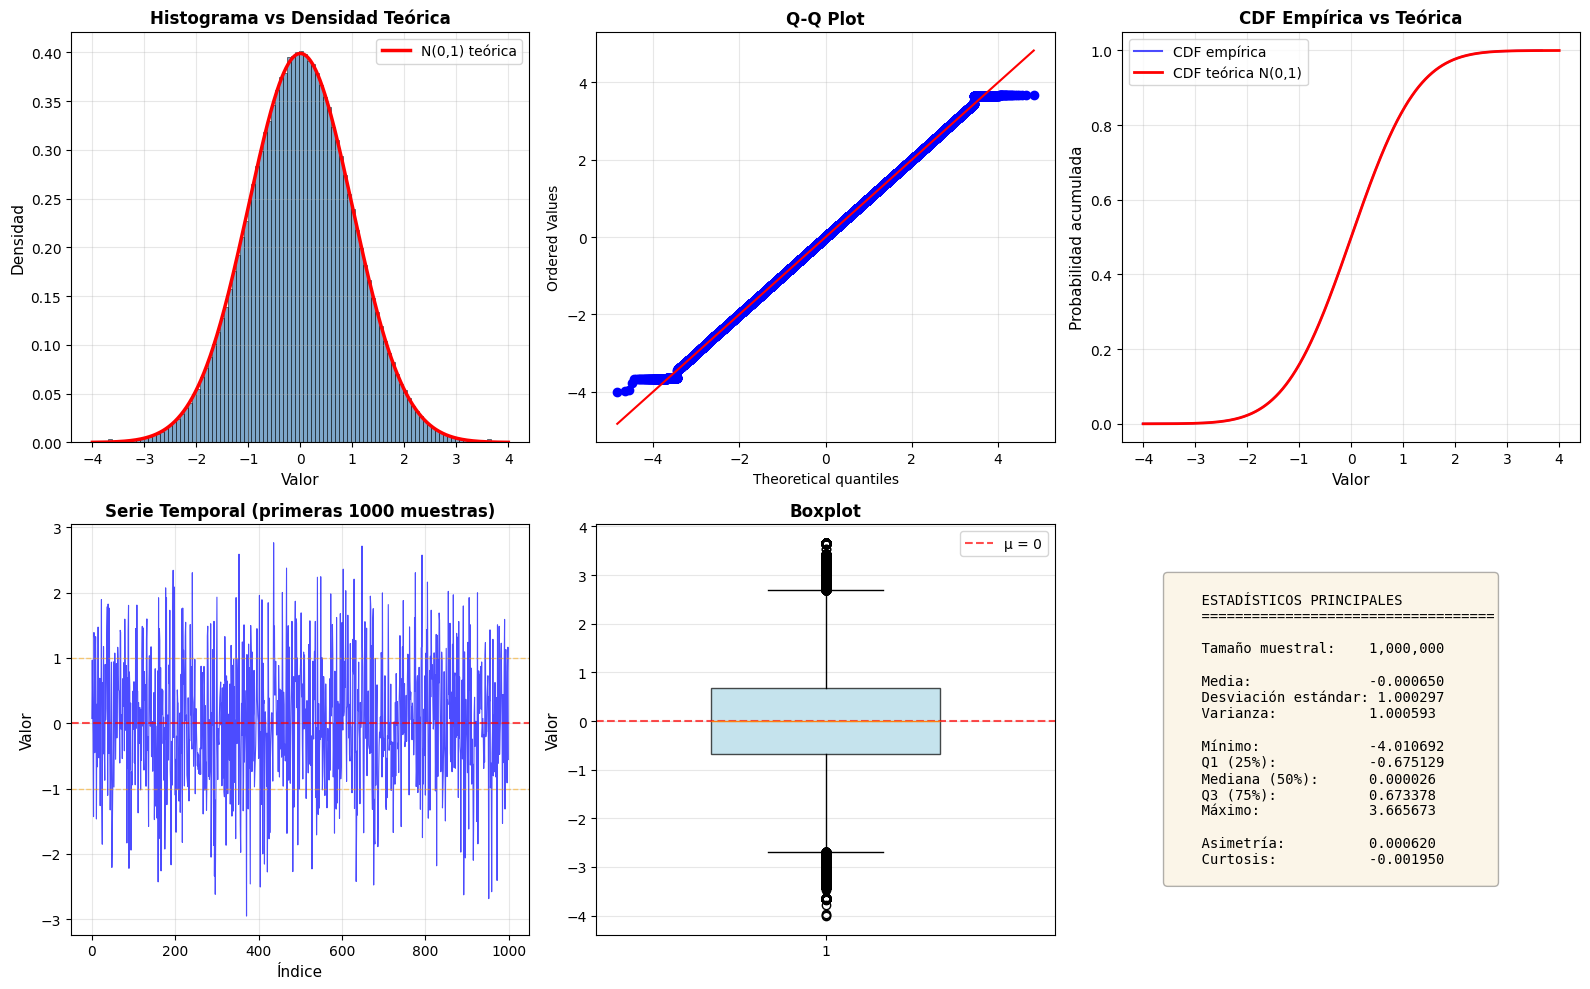


✅ Análisis completo finalizado


In [7]:
# PASO 1: Definir cantidad de muestras a generar
N_MUESTRAS = 1000000 # Puedes cambiar este valor

# PASO 2: Generar muestras
muestras = generar_muestras_ziggurat(n_muestras=N_MUESTRAS, seed=42)

# PASO 3: Realizar tests estadísticos
realizar_tests_estadisticos(muestras)

# PASO 4: Visualizar resultados
visualizar_resultados(muestras, guardar=True)

print("\n✅ Análisis completo finalizado")

In [ ]:

# Crear generador
mt = np.random.MT19937(seed=42)
rng = np.random.Generator(mt)

# Parámetros para N=128 (del paper)
r = 3.442619855899  # x_127 del paper
v = 0.00492867323399

# Generar bordes x_i (esto es simplificado; en producción usar el método del paper)
# Para este ejemplo, usamos una aproximación
N = 128
x_list = np.zeros(N)
x_list[-1] = r

# Calcula bordes hacia atrás usando la relación x_i = f^{-1}(v/x_{i+1} + f(x_{i+1}))
for i in range(N-2, 0, -1):
    f_next = np.exp(-0.5 * x_list[i+1]**2)
    # Para normal: f^{-1}(y) = sqrt(-2*ln(y))
    arg = v / x_list[i+1] + f_next
    if arg > 0:
        x_list[i] = np.sqrt(-2.0 * np.log(arg))
    else:
        x_list[i] = x_list[i+1] * 0.99

x_list[0] = 0.0  # Borde izquierdo

# Generar tablas
k, w, f = generar_tablas_precalculadas(x_list, v)

# Generar muestras
n_samples = 100000
samples = np.array([ziggurat_norm_one(rng, k, w, f, x_list, r) 
                    for _ in range(n_samples)])

print("Estadísticas de las muestras:")
print(f"  Media: {np.mean(samples):.6f} (esperado: 0.0)")
print(f"  Desv. estándar: {np.std(samples):.6f} (esperado: 1.0)")
print(f"  Min: {np.min(samples):.4f}")
print(f"  Max: {np.max(samples):.4f}")

# Test de normalidad visual
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))

plt.subplot(131)
plt.hist(samples, bins=50, density=True, alpha=0.7, edgecolor='black')
x_plot = np.linspace(-4, 4, 100)
plt.plot(x_plot, np.exp(-0.5*x_plot**2)/np.sqrt(2*np.pi), 'r-', lw=2)
plt.title('Histograma vs Densidad Teórica')
plt.xlabel('x')
plt.ylabel('Densidad')

plt.subplot(132)
from scipy import stats
stats.probplot(samples, dist="norm", plot=plt)
plt.title('Q-Q Plot')

plt.subplot(133)
plt.plot(samples[:1000])
plt.title('Primeras 1000 muestras')
plt.xlabel('Índice')
plt.ylabel('Valor')

plt.tight_layout()
plt.savefig('ziggurat_validation.png', dpi=150)
print("\nGráfico guardado como 'ziggurat_validation.png'")